<a href="https://colab.research.google.com/github/bksaini078/fake_news_detection/blob/Bhupender/Model/Fakenews_Detection_Mean_Teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Declaring Libraries and Hyper parameter

In [1]:
#please install contractions 
import numpy as np
import re
import nltk
# import contractions
import string
import pandas as pd
import pandas as pd
import numpy as np
import random
import spacy
import time
import re

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils 
from gensim.test.utils import get_tmpfile
from nltk.corpus import stopwords
import nltk
import en_core_web_sm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import tensorflow as tf
import matplotlib.pyplot as plt

nlp = en_core_web_sm.load()
nltk.download('stopwords')
nltk.download('punkt')
porter=PorterStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import tensorflow as tf 
import tensorflow.keras as tfk
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
import numpy as np
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#this is to enable eager execution
# tf.compat.v1.enable_eager_execution()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing




## without spacy

In [0]:
REGEX = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
             '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

NEWLINE_REGEX = ('[\n\r\t]')
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)


def replace_ne(text: str, nlp) -> str:
    '''
    This function extracts the name entities, and then replace them with the ne labels.
    :param text:
    :type text:
    :return:
    :rtype:
    '''
    doc = nlp(text)
    for ent in doc.ents:
        text = text.replace(ent.text,ent.label_ )
    return text
def textClean(text):
    """
    Get rid of the non-letter and non-number characters
    """
    text = re.sub(REGEX, " ", text)
    text = re.sub(NEWLINE_REGEX, " ", text)
    text=re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = replace_ne(text,nlp)
    text= replace_contractions(text)

    text= stemSentence(text)
    return text




# Whole data set 

In [0]:
path_newlabelled = "/content/drive/My Drive/Colab Notebooks/wholeDataset.csv";

#0- real, 2-fake, 1- mixed, 3-unlabel
data_n = pd.read_csv(path_newlabelled)
# date	source	T_content	author	value
data_n.groupby('value').count()
del data_n['date']
del data_n['source']
del data_n['author']
data_df = data_n.drop(data_n[data_n.value==1].index)
'''here adding unlable data with -1 value , for later use in MEAN teacher'''
df_label= data_df.loc[(data_df['value'] == 0) | (data_df['value'] == 2)]
df_label['value']=df_label['value'].map({0: 1, 2: 0})
df_label.rename(columns={'value':'Label','T_content':'Article'}, inplace=True)
df_label=df_label.reset_index(drop=True)

'''this thing when you do need unlabel data seperately '''
#taking unlabel data 
df_unlabel= data_df.loc[(data_df['value'] == 3)]
df_unlabel['value']=df_unlabel['value'].map({3:''})
df_unlabel.rename(columns={'value':'Label','T_content':'Article'}, inplace=True)
df_unlabel=df_unlabel.reset_index(drop=True)
del df_unlabel['Label']

df_label,df_unlabel

In [0]:
df_label=df_label.dropna()
df_label.groupby('Label').count(), df_unlabel[:100]


In [0]:
#data preprocessing 
data_preprocessing(df_label)


In [0]:
# df_unlabel_x= df_unlabel[:100]
# S= Spacy()
for i in range(len(df_unlabel)):
    
        df_unlabel.loc[i,'Article'] = cleanup(df_unlabel.loc[i,'Article'])
        


#shuffling 
df_unlabel= df_unlabel.sample(frac=1).reset_index(drop=True)

x_unlabelled= df_unlabel['Article'].values
np.save('/content/drive/My Drive/Colab Notebooks/xun_shuffled.npy',x_unlabelled)
# df_unlabel_x

## Data Preprocessing 

1.   data_prerpocessing() this function create without noise 
2.   data_preprocessing_noise() this function creates data with noise 



In [0]:

#calling spacy methodds


def data_preprocessing(data):
    #removing missing rows 
    # S= Spacy()
    missing_rows=[]
    data=data.dropna()

   #cleaning data 
    for i in range(len(data)):
    #with old method 
        data.loc[i, 'Article'] = cleanup(data.loc[i,'Article'])
    # with spacy method 
        # data.loc[i, 'Article'] = S.orchestrate(data.loc[i,'Article'])  
    #converting data. into bool 
    data['Label']= data['Label'].astype(int)

    data['Article']= data['Article'].astype(str)

    #shuffling the dataset 
    data= data.sample(frac=1).reset_index(drop=True)


    train_size = int(0.75 * len(data))
    test_size = len(data) - train_size

    #splitting into test and train
    x_train= data.loc[:train_size,'Article'].values
    y_train= data.loc[:train_size,'Label'].values
    x_test= data.loc[(train_size+1):,'Article'].values
    y_test= data.loc[(train_size+1):,'Label'].values

    #converting into np arrray and hot one encoding 
    y_train = tf.one_hot(y_train,1) # np.array(y_train)
    y_test = tf.one_hot(y_test,1) #np.array(y_test)
    #saving in to numpy files, so again again i dont have to clean the data
    np.save('/content/drive/My Drive/Colab Notebooks/xtr_shuffled.npy',x_train)
    np.save('/content/drive/My Drive/Colab Notebooks/xte_shuffled.npy',x_test)
    np.save('/content/drive/My Drive/Colab Notebooks/ytr_shuffled.npy',y_train)
    np.save('/content/drive/My Drive/Colab Notebooks/yte_shuffled.npy',y_test)
    return



#count of labels in the dataset 
# data.groupby('Label').count()
# data['Article'][0]

In [0]:

#calling spacy methodds


def data_preprocessing(data):
    #removing missing rows 
    # S= Spacy()
    missing_rows=[]
    data=data.dropna()

   #cleaning data 
    for i in range(len(data)):
    #with old method 
        data.loc[i, 'Article'] = cleanup(data.loc[i,'Article'])
    # with spacy method 
        # data.loc[i, 'Article'] = S.orchestrate(data.loc[i,'Article'])  
    #converting data. into bool 
    data['Label']= data['Label'].astype(int)

    data['Article']= data['Article'].astype(str)

    #shuffling the dataset 
    data= data.sample(frac=1).reset_index(drop=True)


    train_size = int(0.75 * len(data))
    test_size = len(data) - train_size

    #splitting into test and train
    x_train= data.loc[:train_size,'Article'].values
    y_train= data.loc[:train_size,'Label'].values
    x_test= data.loc[(train_size+1):,'Article'].values
    y_test= data.loc[(train_size+1):,'Label'].values

    #converting into np arrray and hot one encoding 
    y_train = tf.one_hot(y_train,1) # np.array(y_train)
    y_test = tf.one_hot(y_test,1) #np.array(y_test)
    #saving in to numpy files, so again again i dont have to clean the data
    np.save('/content/drive/My Drive/Colab Notebooks/xtr_shuffled.npy',x_train)
    np.save('/content/drive/My Drive/Colab Notebooks/xte_shuffled.npy',x_test)
    np.save('/content/drive/My Drive/Colab Notebooks/ytr_shuffled.npy',y_train)
    np.save('/content/drive/My Drive/Colab Notebooks/yte_shuffled.npy',y_test)
    return



#count of labels in the dataset 
# data.groupby('Label').count()
# data['Article'][0]

In [0]:
#Reading data 
path_labelled = "/content/drive/My Drive/Colab Notebooks/Labelled_Dataset.csv";

data = pd.read_csv(path_labelled)
data_preprocessing(data)

In [0]:
#Processing of unlabelled data 
path_unlabelled = "/content/drive/My Drive/Colab Notebooks/Unlabeled_dataset.csv";

data_unlabel = pd.read_csv(path_unlabelled,nrows=8297)

#removing missing rows 
missing_rows=[]
for i in range(len(data_unlabel)):
  if data_unlabel.loc[i,'Article'] != data_unlabel.loc[i, 'Article']:
    missing_rows.append(i)
data_unlabel = data_unlabel.drop(missing_rows).reset_index().drop(['index'],axis=1)
#cleaning data 
for i in range(len(data_unlabel)):
        data_unlabel.loc[i,'Article'] = cleanup(data_unlabel.loc[i,'Article'])
        #using spacy
        # data_unlabel.loc[i, 'Article'] = S.orchestrate(data_unlabel.loc[i,'Article'])


#shuffling 
data_unlabel= data_unlabel.sample(frac=1).reset_index(drop=True)

x_unlabelled= data_unlabel['Article'].values
np.save('/content/drive/My Drive/Colab Notebooks/xun_shuffled.npy',x_unlabelled)


In [0]:
#this function to clone from github
# !git clone https://github.com/bksaini078/fake_news_detection.git

Cloning into 'fake_news_detection'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 86 (delta 26), reused 58 (delta 10), pack-reused 0
Unpacking objects: 100% (86/86), done.


# **You can start from here . If you have cleaned the data previously**

In [3]:

import os 
import numpy as np


#these file I have created , to save time of data preprocessing.
if not os.path.isfile('/content/drive/My Drive/Colab Notebooks/xte_shuffled.npy') :
  print("Please clean the data first")
else:
    # x_train = np.load('/content/fake_news_detection/Data_Processing/xtr_shuffled.npy',allow_pickle=True)
    # x_test = np.load('/content/fake_news_detection/Data_Processing/xte_shuffled.npy',allow_pickle=True)
    # y_train = np.load('/content/fake_news_detection/Data_Processing/ytr_shuffled.npy',allow_pickle=True)
    # y_test = np.load('/content/fake_news_detection/Data_Processing/yte_shuffled.npy',allow_pickle=True)
    # x_unlabel=np.load('/content/fake_news_detection/Data_Processing/xun_shuffled.npy',allow_pickle=True)
    #from colab
    x_train = np.load('/content/drive/My Drive/Colab Notebooks/xtr_shuffled.npy',allow_pickle=True)
    x_test = np.load('/content/drive/My Drive/Colab Notebooks/xte_shuffled.npy',allow_pickle=True)
    y_train = np.load('/content/drive/My Drive/Colab Notebooks/ytr_shuffled.npy',allow_pickle=True)
    y_test = np.load('/content/drive/My Drive/Colab Notebooks/yte_shuffled.npy',allow_pickle=True)
    x_unlabel=np.load('/content/drive/My Drive/Colab Notebooks/xun_shuffled.npy',allow_pickle=True)
    

x_train[0]

'free beacon fire top report “ financi transact ” somecardin frequent coveredth gpe free beacon fire cardin top report discov “ financi transact ” report somecardin cover site announc date report person recent accgpe work behalf norp billionair center recent highprofil legal disput date free beacon ’ s leadership publish note say site “ recent learn senior editor person enter previogp undisclos financi transact individu affili individu mr person cover report ” person ask resign accord note so note attach stori person wrote person regularli written date free beacon attach note stori person wrote org begin date note appear attach person ’ s stori org also known mile kwok org norp real estat tycoon involv byzantin legal battl conserv firm hire research peopl connect norp communist parti su deliv contract firm turn accgpe org ’ s team seed malwar devic truli dissid spi beij org later su org organ alleg defam org live gpe vocal critic norp govern appli asylum gpe person menticardinald sever

In [0]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer

max_features = 20000
maxlen = 100
batch_size = 32

tokenizer=Tokenizer (num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
full_article= np.hstack((x_train, x_test,x_unlabel))
tokenizer.fit_on_texts(full_article)
x_train_token=tokenizer.texts_to_sequences(x_train)
x_test_token=tokenizer.texts_to_sequences(x_test)
x_unlabel_token= tokenizer.texts_to_sequences(x_unlabel)


In [5]:
x_train_seq = sequence.pad_sequences(x_train_token, maxlen=maxlen)
x_test_seq=sequence.pad_sequences(x_test_token, maxlen=maxlen)
x_unlabel_tar= sequence.pad_sequences(x_unlabel_token, maxlen= maxlen)
#defining vocalbury size 
vocab_size = len(tokenizer.word_index)+1

x_train= x_train_seq
x_test= x_test_seq
vocab_size,np.shape(x_train), np.shape(y_train),np.shape(x_unlabel_tar),np.shape(x_test),np.shape(y_test)

(47250, (4799, 100), (4799, 1), (4048, 100), (1599, 100), (1599, 1))

In [6]:
def dataset_with_noise(x_train, y_train, x_unlabel, ratio=0.20 , test_train_split=0.25):
    '''this function introduce noise in the training data for mean teacher model , 
    this function is used in calculating classification cost, user have to provide 
    amount of noise he want to addd(ration) and test train split ratio too'''
    #amount of noise need to add in x_train data 
    noise=int(np.shape(x_train)[0]*ratio)
    # taking column of x_train, need it later 
    x_column = np.shape(x_train)[1]

    if noise <= int(np.shape(x_unlabel)[0]):

        #taking number of noise from unlabel data 
        ratio_noise = x_unlabel_tar[:noise]

        # creating -1 label for noise data 
        y_unlabel=np.full((np.shape(ratio_noise)[0], 1), -1)

        # adding noise in train data 
        x = np.append(x_train, ratio_noise, axis=0)
        y = np.append(y_train, y_unlabel, axis=0)
        x = np.append(x,y, axis=1)
        row = np.shape(x)[0]

        # shufflin data 
        x =np.random.permutation(x)

        #seperating label from x 
        y=np.reshape(x[:,x_column],(row,1))

        # splitting into test and train 
        total_len= np.shape(x_train)[0]
        test_split= int(total_len*test_train_split)
        train_split = total_len- test_split
        x_train_n=x[0:train_split,0:x_column]
        x_test_n= x[train_split+1:total_len,0:x_column]

        y_train_n= np.reshape(y[:train_split,0],(train_split,1))
        y_test_n = np.reshape( y[train_split+1:total_len,0],(test_split-1,1))
    else :
        print('error: Insufficient unlabel data available !')

    return x_train_n, y_train_n, x_test_n, y_test_n 

x_train_noise, y_train_noise, x_test_noise, y_test_noise = dataset_with_noise(x_train, y_train, x_unlabel_tar, 0.2, 0.25)
np.shape(x_train_noise),np.shape(y_train_noise), np.shape(x_test_noise), np.shape(y_test_noise)

((3600, 100), (3600, 1), (1198, 100), (1198, 1))

# Model Declaration



In [0]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 64
epochs=6
alpha=0.99
ratio =0.5
lr =0.0005

In [0]:
tf.keras.backend.clear_session()
def BiLstmModel(maxlen, vocab_size):
  inputs = keras.Input(shape=(maxlen,))
  x =Embedding(vocab_size, 128, input_length=None)(inputs)
  x =Bidirectional(LSTM(128))(x)
  x = Dropout(0.2)(x)
  x =Dense(2)(x)
  x =Dense(1, activation='sigmoid')(x)
  return Model(inputs,x)

#Function to create confusion matrix 
def Confusion_matrix(model,x_test,y_true, caption='Confusion matrix'):
    '''this function will create confusion matrix with predicted value and true label'''
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,0.51)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    # print(cm)
    # calculating recall , precision and f1 score 
    tp_and_fp=np.sum(cm[:,1])
    tn_and_fp=np.sum(cm[0,:])
    tp_and_fn = np.sum(cm[1, : ])
    tp_and_tn= np.trace(cm)
    tp=(tp_and_fp-tn_and_fp+tp_and_tn)/2
    
    precision=tp/tp_and_fp 
    recall = tp/tp_and_fn
    accuracy= np.trace(cm)/np.sum(cm)
    # f1_score=sklearn.metrics.f1_score(y_true, y_pred)
    f1_score= (2*precision*recall)/(precision+recall)
    print('Precision:', precision)
    print('Recall:', recall)
    print('f1 Score:', f1_score)
    print('Accuracy:', accuracy)

    import matplotlib.pyplot as plt
    figure = plt.figure(figsize=(8, 8))
    # cm=np.around(cm.astype(int))
    # con_mat_norm = np.around(cm, decimals=4)
    con_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Oranges)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(caption)
    
    plt.show()
    return cm

#to see the plot of the data
# model_supervised.summary(), tf.keras.utils.plot_model(model_supervised,show_shapes=True)

# Supervised Model

In [9]:
#for seeing the result clearly 
%load_ext tensorboard
#deleting already available logs 
!rm -rf ./logs/ 

model_supervised = BiLstmModel(maxlen, vocab_size)
model_supervised.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= lr ),loss= 'binary_crossentropy', metrics=['accuracy'])
print('Train...')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history=model_supervised.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.3,callbacks=[tensorboard_callback])


Train...
Epoch 1/6
53/53 [==============================] - 28s 534ms/step - loss: 0.4951 - accuracy: 0.7315 - val_loss: 0.2041 - val_accuracy: 0.9299
Epoch 2/6
53/53 [==============================] - 28s 521ms/step - loss: 0.1187 - accuracy: 0.9568 - val_loss: 0.1117 - val_accuracy: 0.9556
Epoch 3/6
53/53 [==============================] - 27s 516ms/step - loss: 0.0493 - accuracy: 0.9845 - val_loss: 0.0731 - val_accuracy: 0.9743
Epoch 4/6
53/53 [==============================] - 27s 510ms/step - loss: 0.0593 - accuracy: 0.9678 - val_loss: 0.1128 - val_accuracy: 0.9451
Epoch 5/6
53/53 [==============================] - 27s 514ms/step - loss: 0.1068 - accuracy: 0.9464 - val_loss: 0.1567 - val_accuracy: 0.9271
Epoch 6/6
53/53 [==============================] - 27s 515ms/step - loss: 0.1081 - accuracy: 0.9455 - val_loss: 0.2072 - val_accuracy: 0.9076


In [0]:
#to load the tensor board
%tensorboard --logdir logs/fit

## Plotting result 

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()
show_train_history(history, 'accuracy', 'val_accuracy')
show_train_history(history, 'loss', 'val_loss')


Precision: 0.9900497512437811
Recall: 0.7171171171171171
f1 Score: 0.831765935214211
Accuracy: 0.8993120700437773


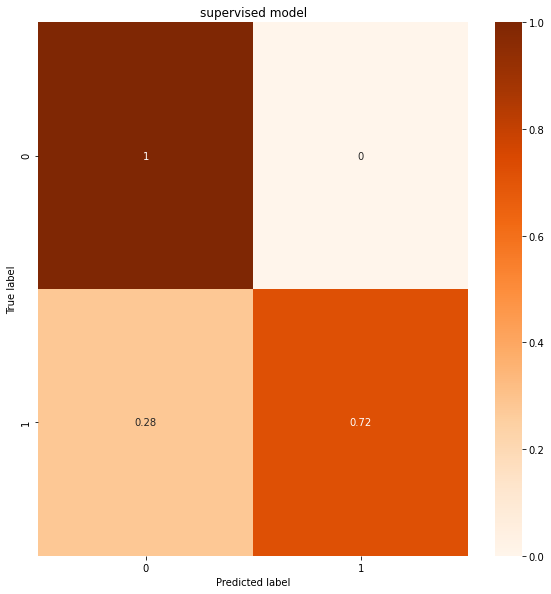

In [10]:
#confusion matrix
conf_matrix=Confusion_matrix(model_supervised,x_test,y_test, 'supervised model')


# MEAN teacher
In this updation takes place during each step/batch. This model doesnt work 

In [9]:
tf.keras.backend.clear_session()
teacher = BiLstmModel(maxlen,vocab_size)
student = BiLstmModel(maxlen,vocab_size)
teacher.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          6048000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 6,311,685
Trainable params: 6,311,685
Non-trainable params: 0
___________________________________________________

In [0]:


#preparing the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noise, y_train_noise))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size)

#preparing the target dataset 
tar_dataset =  tf.data.Dataset.from_tensor_slices(x_test_noise)
tar_dataset = tar_dataset.shuffle(buffer_size=1024).batch(batch_size)



# declaring loss function
def classification_costs(logits, labels):
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating 
    the binary cross entropy .
    """
    applicable = tf.not_equal(labels, -1)

     # Change -1s to zeros to make cross-entropy computable
    labels = tf.where(applicable, labels, tf.zeros_like(labels))

    # This will now have incorrect values for unlabeled examples
    per_sample = tf.keras.losses.binary_crossentropy(labels,logits)
    # Retain costs only for labeled
    per_sample = tf.where(applicable, per_sample, tf.zeros_like(per_sample))
    # Take mean over all examples, not just labeled examples.
    # print('sample', np.shape(per_sample))
    loss = tf.math.divide( tf.reduce_mean(tf.reduce_sum(per_sample)), np.shape(per_sample)[0])

    return loss

#custom loss function
def Overall_Cost(classification_cost, consistency_cost, ratio=0.5):
    return (ratio * classification_cost) + ((1 - ratio)*consistency_cost)
#function for consistency cost 
def Consistency_Cost(teacher_output, student_output):
    sq_diff_layer = tf.reduce_mean(tf.math.squared_difference(teacher_output, student_output))
    return sq_diff_layer
def ema(student_model, teacher_model, alpha=0.99):
    '''
    Calculates the exponential moving average of the student model weights and updates the teacher model weights
    formula:
    t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with default alpha = 0.99
    t_i = weights of teacher model in current epoch
    s_i = weights of student model in current epoch
    '''
    #taking weights 
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    #length must be equal otherwise it will not work 
    assert len(student_weights) == len(teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(
        len(student_weights), len(teacher_weights))

    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha*(teacher_weights[i]) + (1-alpha)*layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model

#declaring metrics and loss function for student and teacher 
#declaring optimiser
optimizer= tf.keras.optimizers.Adam(learning_rate= lr ) #trying changing learning rate , sometimes it gives good result 
train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
val_acc_metric = keras.metrics.BinaryAccuracy(name="Binary_Acc")
teacher_acc_metric = keras.metrics.BinaryAccuracy(name="Binary_Acc_teacher")


* * * * * * * * * * * * * * * * *
Start of epoch 0
* * * * * * * * * * * * * * * * *
Training loss:- Binary Cross entropy (for one batch) at step 0: 39.33502197265625
Consistency Cost: 2.0272495021345094e-05
Seen so far: 64 samples
Overall Cost: 19.66752052307129
--------------- step, batch 0: 64 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 20: 30.109798431396484
Consistency Cost: 0.04320048168301582
Seen so far: 1344 samples
Overall Cost: 15.076498985290527
--------------- step, batch 20: 1344 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 40: 13.410374641418457
Consistency Cost: 0.13177883625030518
Seen so far: 2624 samples
Overall Cost: 6.771076679229736
--------------- step, batch 40: 2624 ---------------------
Training acc over epoch: 61.05555295944214


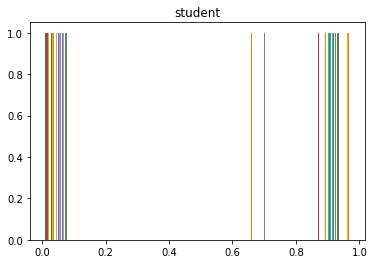

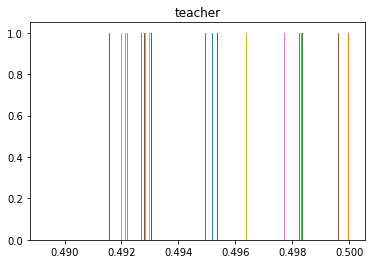

Student Validation acc: 95.3125
Teacher Validation acc: 57.8125
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
Training loss:- Binary Cross entropy (for one batch) at step 0: 3.998335361480713
Consistency Cost: 0.2079891711473465
Seen so far: 64 samples
Overall Cost: 2.1031622886657715
--------------- step, batch 0: 64 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 20: 1.314204454421997
Consistency Cost: 0.2277660369873047
Seen so far: 1344 samples
Overall Cost: 0.7709852457046509
--------------- step, batch 20: 1344 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 40: 0.34083980321884155
Consistency Cost: 0.22050905227661133
Seen so far: 2624 samples
Overall Cost: 0.28067442774772644
--------------- step, batch 40: 2624 ---------------------
Training acc over epoch: 82.77778029441833


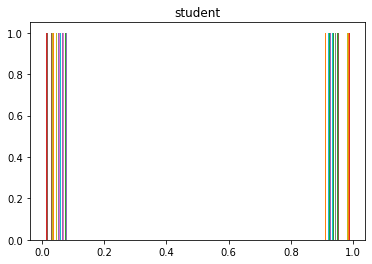

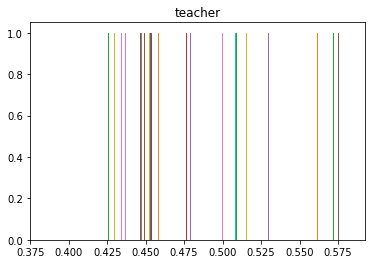

Student Validation acc: 100.0
Teacher Validation acc: 90.625
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
Training loss:- Binary Cross entropy (for one batch) at step 0: 1.188655972480774
Consistency Cost: 0.19941726326942444
Seen so far: 64 samples
Overall Cost: 0.694036602973938
--------------- step, batch 0: 64 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 20: 0.10619409382343292
Consistency Cost: 0.17418897151947021
Seen so far: 1344 samples
Overall Cost: 0.14019152522087097
--------------- step, batch 20: 1344 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 40: 0.02490043267607689
Consistency Cost: 0.13166272640228271
Seen so far: 2624 samples
Overall Cost: 0.07828158140182495
--------------- step, batch 40: 2624 ---------------------
Training acc over epoch: 83.44444632530212


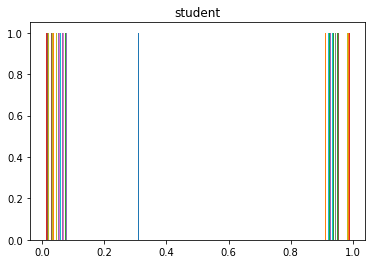

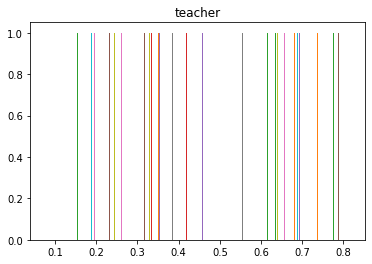

Student Validation acc: 98.4375
Teacher Validation acc: 98.4375
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
Training loss:- Binary Cross entropy (for one batch) at step 0: 0.022665629163384438
Consistency Cost: 0.09134586155414581
Seen so far: 64 samples
Overall Cost: 0.05700574442744255
--------------- step, batch 0: 64 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 20: 0.030758406966924667
Consistency Cost: 0.03691691532731056
Seen so far: 1344 samples
Overall Cost: 0.033837661147117615
--------------- step, batch 20: 1344 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 40: 0.023029694333672523
Consistency Cost: 0.02911544032394886
Seen so far: 2624 samples
Overall Cost: 0.026072567328810692
--------------- step, batch 40: 2624 ---------------------
Training acc over epoch: 83.22222232818604


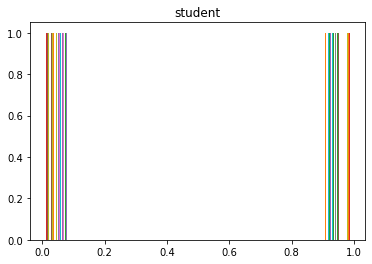

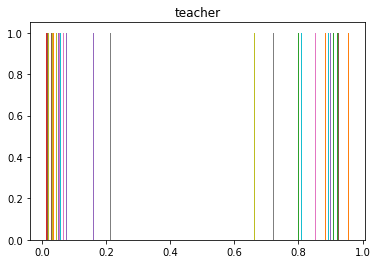

Student Validation acc: 100.0
Teacher Validation acc: 100.0
* * * * * * * * * * * * * * * * *
Start of epoch 4
* * * * * * * * * * * * * * * * *
Training loss:- Binary Cross entropy (for one batch) at step 0: 0.3392871022224426
Consistency Cost: 0.01605352945625782
Seen so far: 64 samples
Overall Cost: 0.17767031490802765
--------------- step, batch 0: 64 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 20: 0.027959533035755157
Consistency Cost: 0.019782429561018944
Seen so far: 1344 samples
Overall Cost: 0.023870982229709625
--------------- step, batch 20: 1344 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 40: 0.05171997472643852
Consistency Cost: 0.0019969106651842594
Seen so far: 2624 samples
Overall Cost: 0.026858443394303322
--------------- step, batch 40: 2624 ---------------------
Training acc over epoch: 83.5277795791626


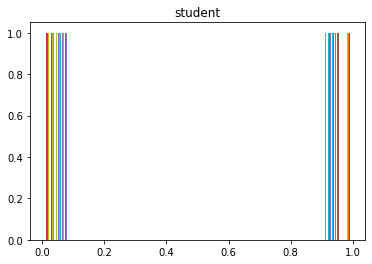

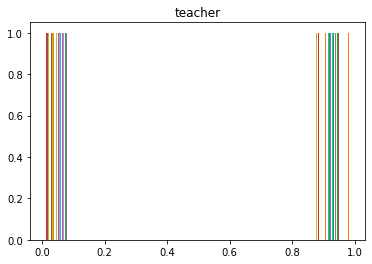

Student Validation acc: 100.0
Teacher Validation acc: 100.0
* * * * * * * * * * * * * * * * *
Start of epoch 5
* * * * * * * * * * * * * * * * *
Training loss:- Binary Cross entropy (for one batch) at step 0: 0.017529426142573357
Consistency Cost: 0.0022323536686599255
Seen so far: 64 samples
Overall Cost: 0.009880890138447285
--------------- step, batch 0: 64 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 20: 0.021853458136320114
Consistency Cost: 0.0002193156979046762
Seen so far: 1344 samples
Overall Cost: 0.011036386713385582
--------------- step, batch 20: 1344 ---------------------
Training loss:- Binary Cross entropy (for one batch) at step 40: 0.039176251739263535
Consistency Cost: 0.008143258281052113
Seen so far: 2624 samples
Overall Cost: 0.023659754544496536
--------------- step, batch 40: 2624 ---------------------
Training acc over epoch: 83.5277795791626


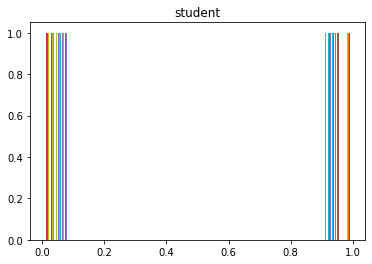

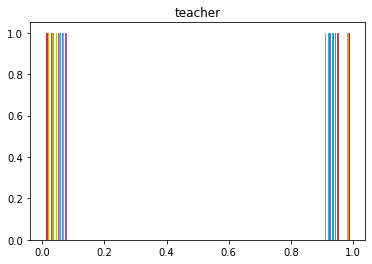

Student Validation acc: 100.0
Teacher Validation acc: 100.0


In [11]:
#this one for collecting the costs 
consistency=[]
overall=[]
classification=[]
train_accuracy=[]
steps=[]



# iterator_unlabel = iter(tar_dataset)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size)

#training teacher with one epoch 
# teacher.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# teacher.fit(x_train, y_train, epochs=1, shuffle= True, verbose=2, validation_split=0.3, batch_size=batch_size) #validation_data=(x_test,y_test)
#this I am doing to get all steps details in epoch
i=0
for epoch in range(epochs):  
   print(*"*****************")
   print('Start of epoch %d' % (epoch,))
   print(*"*****************")
   #iteration over batches 
   for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      with tf.GradientTape() as tape:
         
        # Run the forward pass of the layer
         logits= student(x_batch_train, training= True)   
         train_metrics(y_batch_train,logits)  

         #Calculating classification cost 
         classification_cost = classification_costs(logits,y_batch_train)
         classification.append(classification_cost)
         
         #calculating consistency cost for unlabelled dataset
         iterator_unlabel = iter(tar_dataset)
         x_batch_tar = iterator_unlabel.get_next()
         tar_student = student(x_batch_tar)
         tar_teacher = teacher(x_batch_tar)
         consistency_cost= Consistency_Cost(tar_teacher,tar_student) 
         consistency.append(consistency_cost)

         overall_cost= Overall_Cost(classification_cost, consistency_cost, ratio=0.5)
         overall.append(overall_cost)
        #  consistency_cost = consistency_cost #this is ratio 
         #adding loss to student model 
         
         
      
      grads= tape.gradient(overall_cost, student.trainable_weights)
      i=i+1
      steps.append(i)
    
   
    # the value of the variables to minimize the loss.
      optimizer.apply_gradients(zip(grads, student.trainable_weights))
      teacher= ema(student, teacher, alpha=alpha)
      if step % 20==0:
          print('Training loss:- Binary Cross entropy (for one batch) at step %s: %s' % (step, float(classification_cost)))
          print("Consistency Cost: %s" % (float(consistency_cost)))
          print('Seen so far: %s samples' % ((step + 1) * batch_size))
          print("Overall Cost: %s" % (float(overall_cost)))
          print("--------------- step, batch %s: %s ---------------------"% (step,((step + 1) * batch_size)))
   
   
   train_acc = train_metrics.result()
   
   #appending training accuracy
   train_accuracy.append(train_acc)

   print('Training acc over epoch: %s' % (float(train_acc)*100,))
    # Reset training metrics at the end of each epoch
   train_metrics.reset_states()
   
  # Run a validation loop at the end of each epoch.
   val_acc_metric.reset_states()
   teacher_acc_metric.reset_states()
   iterator_val = iter(val_dataset)
   x_batch_val, y_batch_val = iterator_val.get_next()
   val_logits = student(x_batch_val)
   plt.hist(val_logits)
   plt.title('student')
   plt.show()
   val_logits_t = teacher(x_batch_val)
   plt.hist(val_logits_t)
   plt.title('teacher')
   plt.show()


   val_acc_metric(y_batch_val, val_logits)
   teacher_acc_metric(y_batch_val, val_logits_t)
   val_acc = val_acc_metric.result()
   val_acc_t= teacher_acc_metric.result()
  

   print('Student Validation acc: %s' % (float(val_acc)*100,))
   print('Teacher Validation acc: %s' % (float(val_acc_t)*100,))
   
   #saving weights on the run
#    if epoch % 9==0:
#         #saving the weights
#         print("saving weights")
#         student.save_weights("/content/student_save")
#         teacher.save_weights("/content/teacher_save")


Precision: 0.9735915492957746
Recall: 0.9963963963963964
f1 Score: 0.9848619768477294
Accuracy: 0.9893683552220137


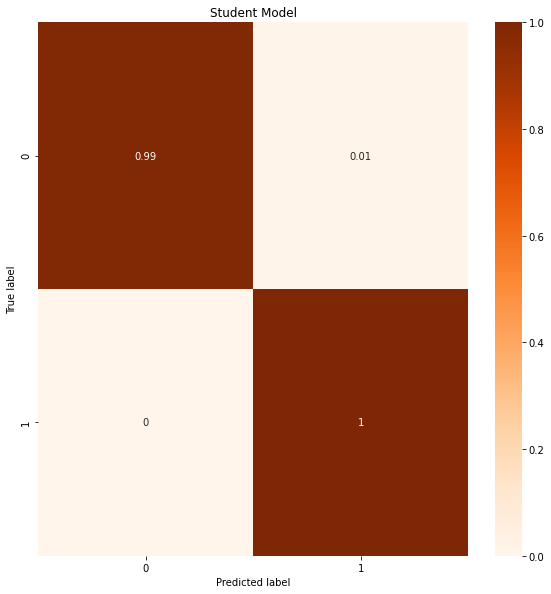

Precision: 0.9648506151142355
Recall: 0.9891891891891892
f1 Score: 0.9768683274021354
Accuracy: 0.983739837398374


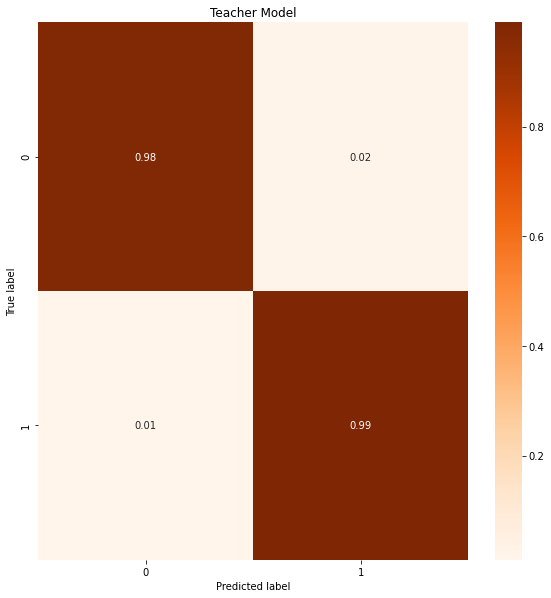

In [14]:
# confusion Matrix 
conf_student=Confusion_matrix(student, x_test,y_test,'Student Model')
conf_teacher=Confusion_matrix(teacher,x_test,y_test,'Teacher Model')


In [75]:
# tp_and_fn = cm.sum(1)
# tp_and_fp = cm.sum(0)
# tp = np.trace(cm)

# precision = tp / tp_and_fp
# recall = tp / tp_and_fn
tp_and_fp=np.sum(conf_student[:,1])
tp_and_fn=np.sum(conf_student[1,:])
tn_and_fp=np.sum(conf_student[0,:])
tp_and_tn= np.trace(conf_student)
total = np.sum(conf_student) 
tp=(tp_and_fp-tn_and_fp+tp_and_tn)/2
fp=tp_and_fp-tp
precision=tp/tp_and_fp 
recall = tp/tp_and_fn
f1= 2*recall*precision/(recall+precision)


(0.9615384615384616, 0.990990990990991, 0.933786078098472)

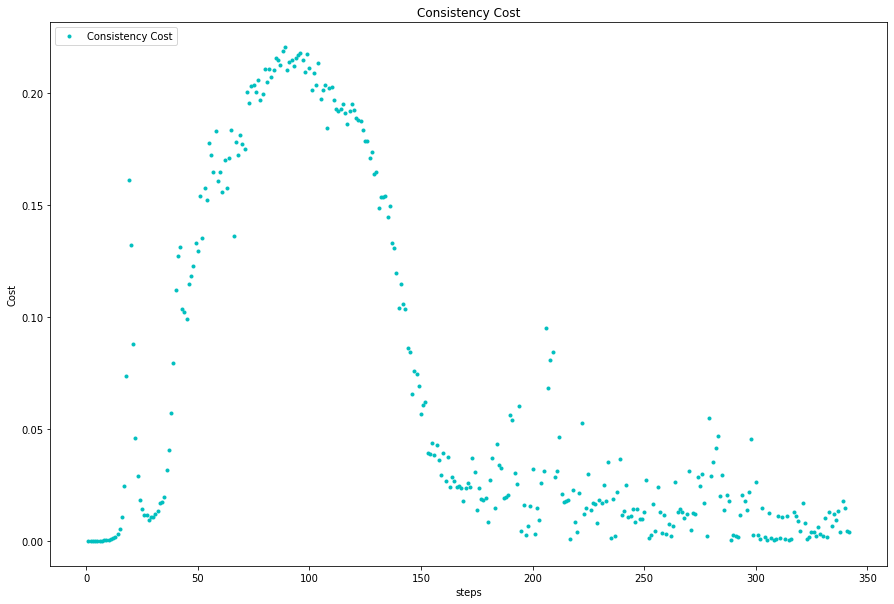

In [14]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(15, 10))
plt.plot(steps, consistency,'.', color='c')
# plt.plot(steps, classification, color='b')
# plt.plot(steps, overall, color='k')
plt.title('Consistency Cost')
plt.ylabel('Cost')
plt.xlabel('steps')
plt.legend(['Consistency Cost'], loc = 'upper left')
plt.show()



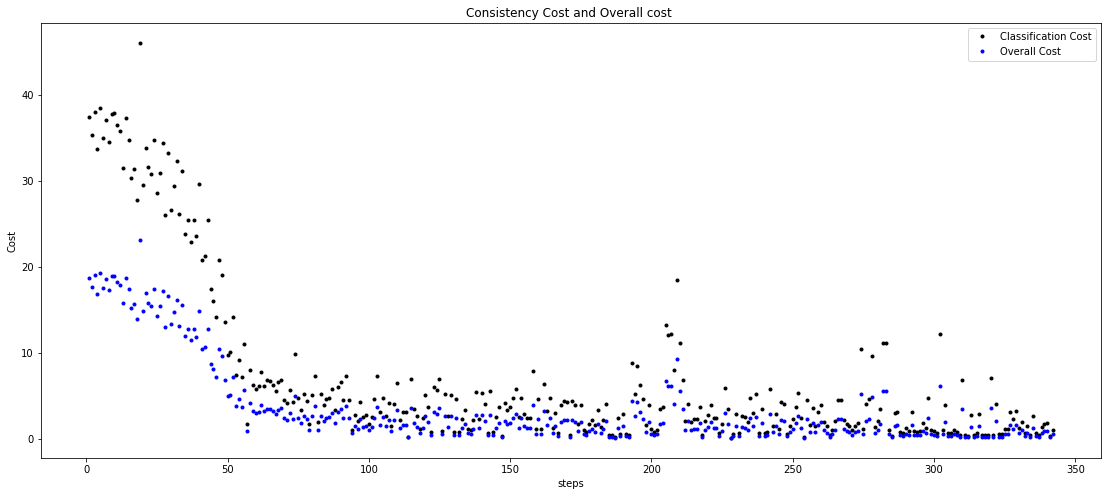

In [15]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(19, 8))
plt.plot(steps, classification, '.',color='k')
plt.plot(steps, overall,'.', color='b')

plt.title('Consistency Cost and Overall cost ')
plt.ylabel('Cost')
plt.xlabel('steps')
plt.legend(['Classification Cost', 'Overall Cost'], loc = 'upper right')
plt.show()
